In [1]:
from utils import preprocess_text, labelnum

import os
from glob import glob
from pathlib import Path
from datetime import timedelta, datetime, timezone

import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [6]:
sns.set_theme(style="whitegrid", palette="pastel")

In [3]:
DATA_PATH = Path('./data/processed/20-MAD/nlp')

In [4]:
commits = pd.read_csv(DATA_PATH / 'commits.csv')
commits.head()

,source,repo,hash,parents,author,author_time,author_tz,committer,commit_time,commit_tz,...,added,removed,from_svn,accurate_tz,issue_id,message_sentiment,local_commit_time,local_author_time,part_of_day_commit,part_of_day_author
0,apache,accumulo-bsp,02eebbd572b5a3308cb17910c1ad5a368fe3bb5c,3581adc7c5de0dc223eea3604fd6c4327801dd39,58d05bc1bf093c031c0caead30d37b44c48bdaf1,2013-01-15 23:58:38+00:00,0,58d05bc1bf093c031c0caead30d37b44c48bdaf1,2013-01-15 23:58:38+00:00,0,...,329.0,215.0,True,False,12550786.0,neutral,2013-01-15 23:58:38+00:00,2013-01-15 23:58:38+00:00,Night,Night
1,apache,accumulo-bsp,28339e68f0c666a99f2194b0b725951f7c5a75b4,02eebbd572b5a3308cb17910c1ad5a368fe3bb5c,58d05bc1bf093c031c0caead30d37b44c48bdaf1,2013-01-22 18:08:30+00:00,0,58d05bc1bf093c031c0caead30d37b44c48bdaf1,2013-01-22 18:08:30+00:00,0,...,8.0,4.0,True,False,12608497.0,neutral,2013-01-22 18:08:30+00:00,2013-01-22 18:08:30+00:00,Evening,Evening
2,apache,accumulo-bsp,3581adc7c5de0dc223eea3604fd6c4327801dd39,a4df0d433396a227e8a119c141283e6f0b32c575,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-17 17:24:30+00:00,0,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-17 17:24:30+00:00,0,...,1.0,1.0,True,False,12550786.0,neutral,2012-05-17 17:24:30+00:00,2012-05-17 17:24:30+00:00,Afternoon,Afternoon
3,apache,accumulo-bsp,817f8732b84fe4bda588492c5bb54f9ea958c74b,e69d32cde486aa5d7a0766b032880e9e13d991b5,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-16 14:51:58+00:00,0,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-16 14:51:58+00:00,0,...,3.0,6.0,True,False,12556041.0,neutral,2012-05-16 14:51:58+00:00,2012-05-16 14:51:58+00:00,Afternoon,Afternoon
4,apache,accumulo-bsp,a4df0d433396a227e8a119c141283e6f0b32c575,fe3ff84ecb2a6fc69f0e05ced668013636c8c591,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-16 17:42:07+00:00,0,83273207ef443072fc57aa858fff07fd5697a4a8,2012-05-16 17:42:07+00:00,0,...,16.0,0.0,True,False,12556041.0,neutral,2012-05-16 17:42:07+00:00,2012-05-16 17:42:07+00:00,Afternoon,Afternoon


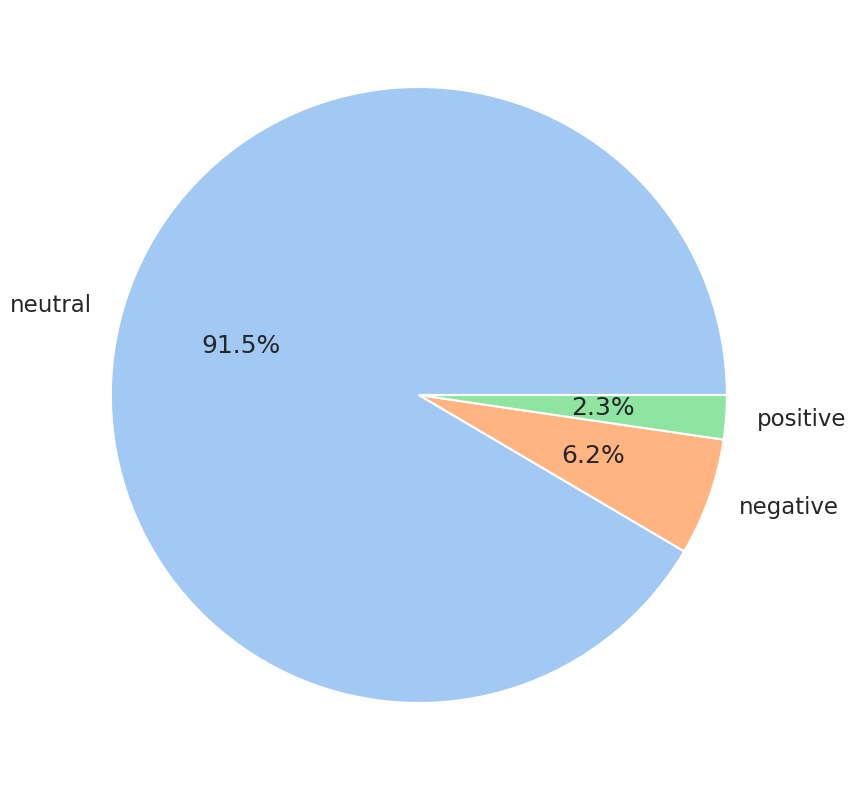

In [17]:
# Commit Message Sentiment Composition
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("pastel")
sns.set_style("whitegrid")
sns.set_context("talk")
commits['message_sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [20]:
issues = pd.read_csv(DATA_PATH / 'issues.csv')
issues.head()

/tmp/ipykernel_365242/2737163175.py:1: DtypeWarning: Columns (3,6,8,9,10,12,14,18,19,20,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  issues = pd.read_csv(DATA_PATH / 'issues.csv')


,source,product,issue_id,issue_key,created,updated,last_resolved,summary,description,version,...,component,votes,product_name,reporter_key,reporter_tz,creator_key,creator_tz,assignee_key,assignee_tz,summary_sentiment
0,apache,AAR,12962708,AAR-1,2016-04-26 19:11:19+00:00,2016-04-26 19:11:19+00:00,NaN,1-800-790-9186 Epson Tech Support TelePhone Nu...,help1-800-790-9186 FREE Epson Tech Support Tel...,NaN,...,NaN,0,aardvark,49ea46c1f294ed796cd22d25c0855d53baf041d8,Etc/UTC,49ea46c1f294ed796cd22d25c0855d53baf041d8,Etc/UTC,NaN,NaN,neutral
1,apache,AAR,12962764,AAR-2,2016-04-26 21:55:25+00:00,2016-04-26 21:55:25+00:00,NaN,pogo games customer service phone number 1855 ...,pogo games customer service phone number 1855 ...,NaN,...,NaN,0,aardvark,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,NaN,NaN,neutral
2,apache,AAR,12962773,AAR-3,2016-04-26 22:31:01+00:00,2016-04-26 22:31:01+00:00,NaN,KUND pogo games customer service phone number ...,pogo games customer service phone number 1844 ...,NaN,...,NaN,0,aardvark,519f21bba765cb60b50704d3ffc26723c3a9ae4f,Etc/UTC,519f21bba765cb60b50704d3ffc26723c3a9ae4f,Etc/UTC,NaN,NaN,neutral
3,apache,AAR,12962774,AAR-4,2016-04-26 22:31:47+00:00,2016-04-26 22:31:47+00:00,NaN,"phone number 1855 800 8493, Pogo games tech Su...",pogo games customer service phone number 1855 ...,NaN,...,NaN,0,aardvark,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,NaN,NaN,neutral
4,apache,AAR,12962776,AAR-5,2016-04-26 22:32:28+00:00,2016-04-26 22:32:28+00:00,NaN,"call, 1855 800 8493 for all type help by Pogo ...",pogo games customer service phone number 1855 ...,NaN,...,NaN,0,aardvark,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,deec89d8f75a320906c444c0157b54f160cc80f4,Etc/UTC,NaN,NaN,neutral


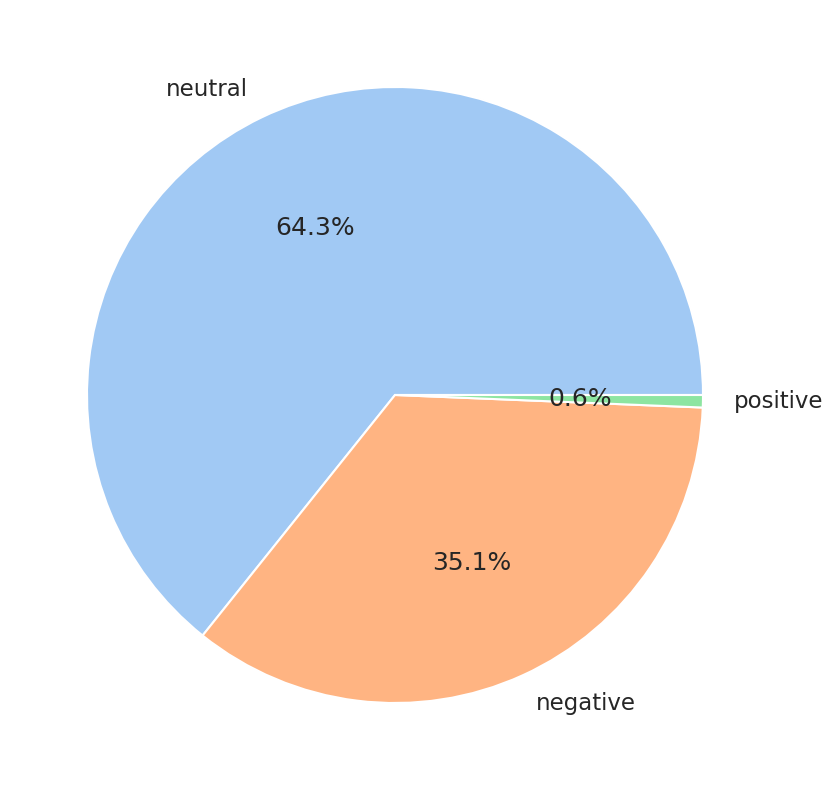

In [21]:
# Issue Summary Sentiment Composition
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("pastel")
sns.set_style("whitegrid")
sns.set_context("talk")
issues['summary_sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [22]:
issue_comments = pd.read_csv(DATA_PATH / 'issue_comments_01.csv')
issue_comments.head()

,source,product,issue_id,comment_id,count,author_key,author_tz,update_author_key,update_author_tz,created,updated,index,text,text_sentiment
0,apache,AAR,12963270.0,15261151.0,NaN,14e647a68666823ae46697258899ac0b0a681de6,Etc/UTC,14e647a68666823ae46697258899ac0b0a681de6,Etc/UTC,2016-04-27 23:04:37+00:00,2016-04-27 23:05:24+00:00,2,"Watch The Ultimate Fighter Season 23, Episode ...",neutral
1,apache,AAR,12963426.0,15261824.0,NaN,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,2016-04-28 09:16:51+00:00,2016-04-28 09:16:51+00:00,3,faqegggf,neutral
2,apache,AAR,12963426.0,15262448.0,NaN,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,2016-04-28 16:30:42+00:00,2016-04-28 16:30:42+00:00,4,geadggdgdg,neutral
3,apache,AAR,12963426.0,15262452.0,NaN,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,2016-04-28 16:31:30+00:00,2016-04-28 16:31:30+00:00,5,gaeggg,negative
4,apache,AAR,12963426.0,15262453.0,NaN,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,dbea2a0f9161664766394eaeae89d872577bc764,Europe/Berlin,2016-04-28 16:31:50+00:00,2016-04-28 16:31:50+00:00,6,fegf,neutral


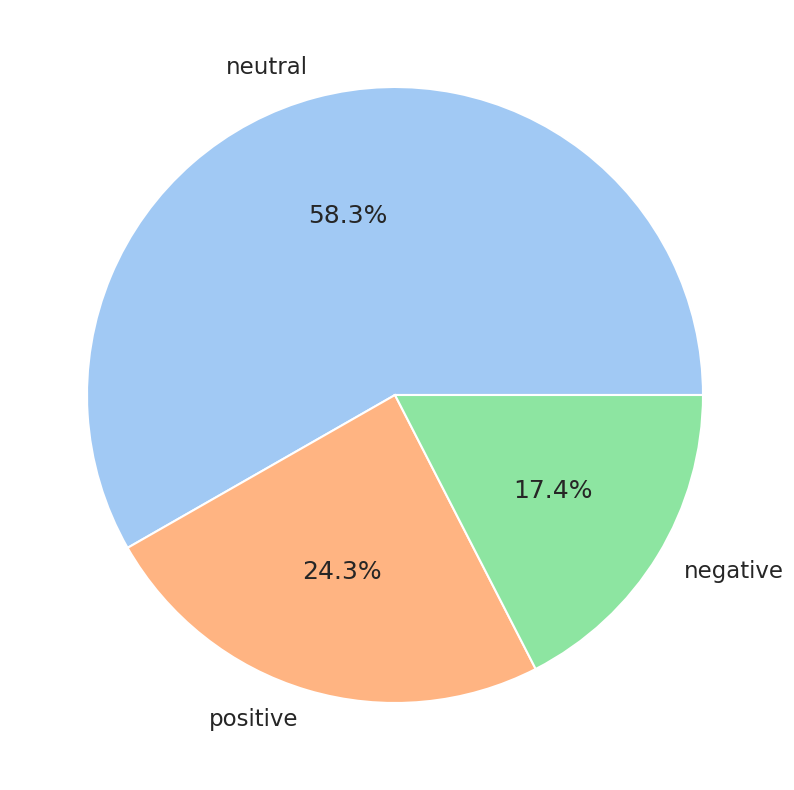

In [23]:
# Issue Comment Text Sentiment Composition
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("pastel")
sns.set_style("whitegrid")
sns.set_context("talk")
issue_comments['text_sentiment'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

In [8]:
# load issue_comments


In [9]:
issue_comments.columns

Index(['source', 'product', 'issue_id', 'comment_id', 'count', 'author_key',
       'author_tz', 'update_author_key', 'update_author_tz', 'created',
       'updated', 'index', 'text', 'text_sentiment'],
      dtype='object')

In [10]:
eval = pd.read_csv('./models/evaluation/evaluated.csv')
eval.iloc[:, 1:] = eval.iloc[:, 1:] * 100
# save to csv
eval.to_csv('./models/evaluation/eval_table.csv', index=False)
eval.head()

,model,mcc,micro_f1,micro_precision,micro_recall,macro_f1,macro_precision,macro_recall,precision_negative,precision_neutral,precision_positive,recall_negative,recall_neutral,recall_positive,f1_negative,f1_neutral,f1_positive
0,seBERT,79.063066,87.161040,87.161040,87.161040,85.858362,85.987672,85.765828,88.702929,89.312169,79.947917,84.969940,90.460879,81.866667,86.796315,89.882854,80.895916
1,SentiStrength-SE_v1.5,51.826979,71.223022,71.223022,71.223022,66.515273,73.592082,64.008503,78.547855,68.968318,73.260073,47.695391,90.996785,53.333333,59.351621,78.465804,61.728395


In [3]:
rq1 = pd.read_csv('./data/processed/20-MAD/rq/rq1_full_dataset.csv')
rq1.head()

,repo,committer,R,di,C,negative,neutral,positive,commiter frequency
0,camel,006d9c4a5925af5d8d7e52c1311f7381e890c56b,0.000314,12,21,0,21,0,medium
1,camel,01395775028cc76b0146d0ab7d59b13f55c107df,0.000112,3,5,0,5,0,medium
2,camel,029d7545ecac8effb947da79244fa4303e248a9e,0.000566,22,44,0,44,0,high
3,camel,02b398add21c5d64e44829f3817f21a829787dce,0.001443,70,208,13,195,0,high
4,camel,03053480b7b1f0f88aa15206d51b75a224ea5c78,0.000329,8,9,1,8,0,medium


In [4]:
rq3_4 = pd.read_csv('./data/processed/20-MAD/rq/rq3_rq4_merged.csv')
rq3_4.head()

,product_name,issue_id,comment_id,priority,issuetype,text_sentiment
0,Directory,13321.0,16249.0,Critical,Task,negative
1,Directory,13321.0,16250.0,Critical,Task,neutral
2,Directory ApacheDS,13322.0,16251.0,Critical,Bug,neutral
3,Avalon,13491.0,16253.0,Major,Bug,neutral
4,Directory,13555.0,26464.0,Critical,Task,neutral


In [5]:
len(rq3_4)

988571

In [2]:
og_issue = pd.read_csv("./data/processed/20-MAD/issue_comments.csv")

/tmp/ipykernel_5553/1768556512.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  og_issue = pd.read_csv("./data/processed/20-MAD/issue_comments.csv")


In [5]:
issues = pd.read_csv("./data/processed/20-MAD/issues.csv")

/tmp/ipykernel_13397/4096573144.py:1: DtypeWarning: Columns (3,6,8,9,10,12,14,18,19,20,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  issues = pd.read_csv("./data/processed/20-MAD/issues.csv")


In [6]:
issues["priority"].value_counts()

priority
--          1093268
Major        582743
Minor        177287
P3           135794
P1            65110
P2            63461
P5            51990
Critical      39798
Blocker       28302
Trivial       26907
P4            21439
Normal         8359
Low            6473
Urgent          590
High             11
Name: count, dtype: int64

In [7]:
issues["severity"].value_counts()

severity
normal         1118689
critical         92066
major            78500
enhancement      65072
minor            44653
trivial          18208
blocker          13874
Name: count, dtype: int64

In [13]:
issues["source"].value_counts()

source
mozilla    1431062
apache      883064
Name: count, dtype: int64

In [18]:
# find number of issues where source is JIRA and issuetype is Bug
len(issues[(issues["source"] == "apache") & (issues["issuetype"] == "Bug")])

469040

In [19]:
len(issues[(issues["source"] == "mozilla") & (issues["issuetype"] == "Bug")])

0

In [21]:
issues[issues["source"] == "mozilla"]["issuetype"]

883064     NaN
883065     NaN
883066     NaN
883067     NaN
883068     NaN
          ... 
2314121    NaN
2314122    NaN
2314123    NaN
2314124    NaN
2314125    NaN
Name: issuetype, Length: 1431062, dtype: object

In [10]:
issues[issues["severity"].isin(["blocker", "critical", "major", "minor", "trivial"])]["issuetype"].value_counts()

Series([], Name: count, dtype: int64)

In [8]:
len(issues) - 1118689

1195437

In [ ]:
issues[issues["priority"] in [""]]["issuetype"].value_counts()

In [2]:
issue_comments = pd.read_csv("./data/processed/20-MAD/issue_comments.csv")

/tmp/ipykernel_13397/657467561.py:1: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  issue_comments = pd.read_csv("./data/processed/20-MAD/issue_comments.csv")


In [4]:
len(issue_comments) * 0.2

3087994.2

In [2]:
issues_pq = pq.read_table("./data/20-MAD/issues.parquet").to_pandas()

In [4]:
issues_pq[issues_pq["source"] != "apache"]["issuetype"].value_counts()

Series([], Name: count, dtype: int64)

In [5]:
issues2 = pd.read_parquet("./data/20-MAD/issues.parquet")

In [12]:
len(issues2[(issues2["issuetype"].notnull()) & (issues2["issuetype"] != " ")])

883065

In [11]:
len(issues2[(issues2["issuetype"].notnull())])

883065

In [14]:
issues2[issues2["issuetype"] == "New Bugzilla Project"]

,source,product,issue_id,issue_key,created,updated,last_resolved,summary,description,version,...,resolution,component,votes,product_name,reporter_key,reporter_tz,creator_key,creator_tz,assignee_key,assignee_tz
443178,apache,INFRA,13003427,INFRA-12587,2016-09-08 03:23:59+00:00,2017-06-17 07:31:20+00:00,NaT,Request for a new bugzilla project,None,None,...,Resolved,JIRA,0,Infrastructure,34f9f5a9e096129782c9da496570c3e39b7e7c5b,Etc/UTC,34f9f5a9e096129782c9da496570c3e39b7e7c5b,Etc/UTC,None,None
